## eDo Single Axis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

def read_data(file_path):
    column_names = ['zeitstempel','id','m101','m102','m103','m104','m105','m201','m203','m204']
    data = pd.read_csv(file_path,header = None, names = column_names,comment=';')
    return data

def feature_normalize(dataset):
    #Compute the arithmetic mean along the specified axis.
    mu = np.mean(dataset,axis = 0)
    #Compute the standard deviation along the specified axis.
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(supplotTitel,data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5,ax6,ax7) = plt.subplots(nrows = 8, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['zeitstempel'], data['m101'], 'm101')
    plot_axis(ax1, data['zeitstempel'], data['m102'], 'm102')
    plot_axis(ax2, data['zeitstempel'], data['m103'], 'm103')
    plot_axis(ax3, data['zeitstempel'], data['m104'], 'm104')
    plot_axis(ax4, data['zeitstempel'], data['m105'], 'm105')
    plot_axis(ax5, data['zeitstempel'], data['m201'], 'm201')
    plot_axis(ax6, data['zeitstempel'], data['m203'], 'm203')
    plot_axis(ax7, data['zeitstempel'], data['m204'], 'm204')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(supplotTitel)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [4]:
dataset = read_data('input/kerasformat1d_edo_singleaxis.csv')
dataset.dropna(axis=0, how='any', inplace= True)
dataset['m101'] = feature_normalize(dataset['m101'])
dataset['m102'] = feature_normalize(dataset['m102'])
dataset['m103'] = feature_normalize(dataset['m103'])
dataset['m104'] = feature_normalize(dataset['m104'])
dataset['m105'] = feature_normalize(dataset['m105'])
dataset['m201'] = feature_normalize(dataset['m201'])
dataset['m203'] = feature_normalize(dataset['m203'])
dataset['m204'] = feature_normalize(dataset['m204'])

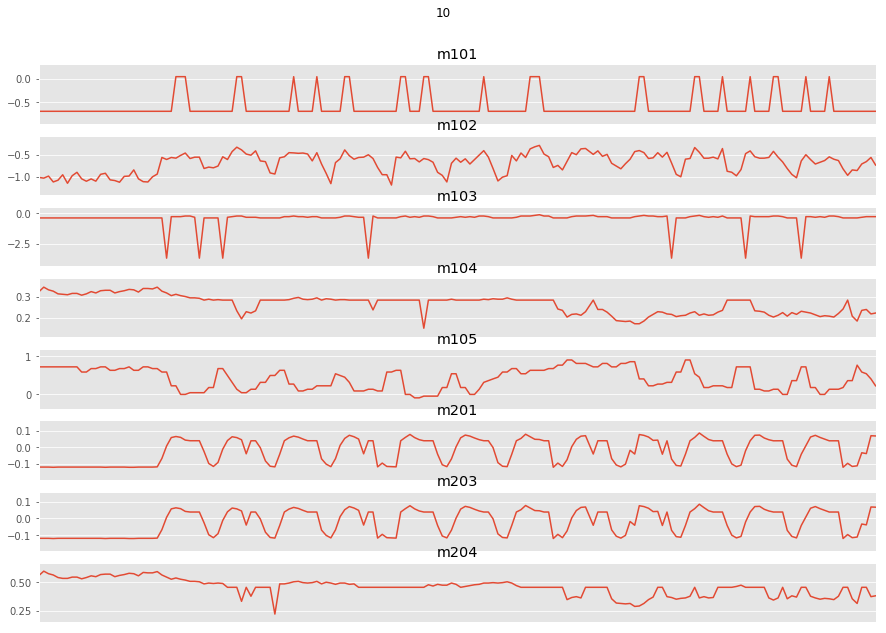

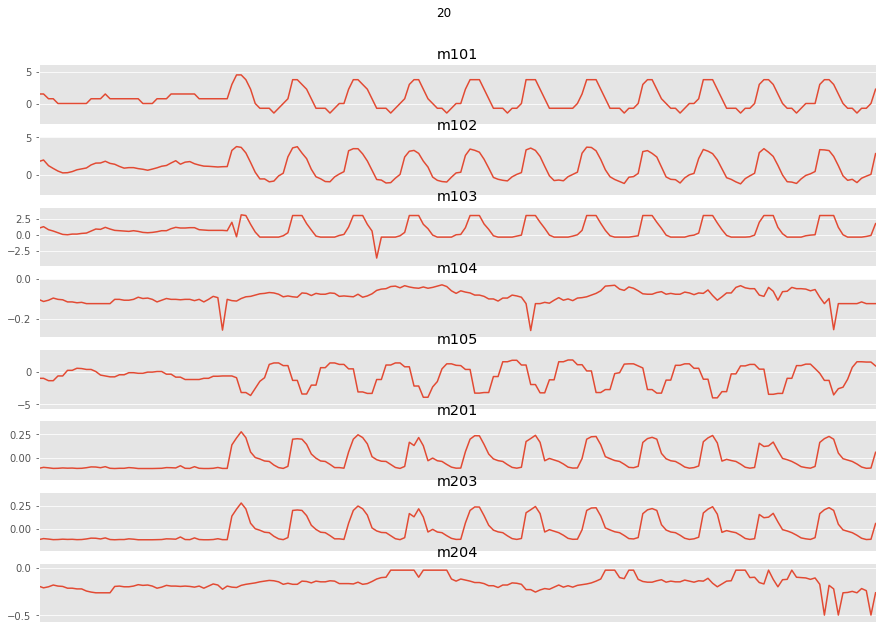

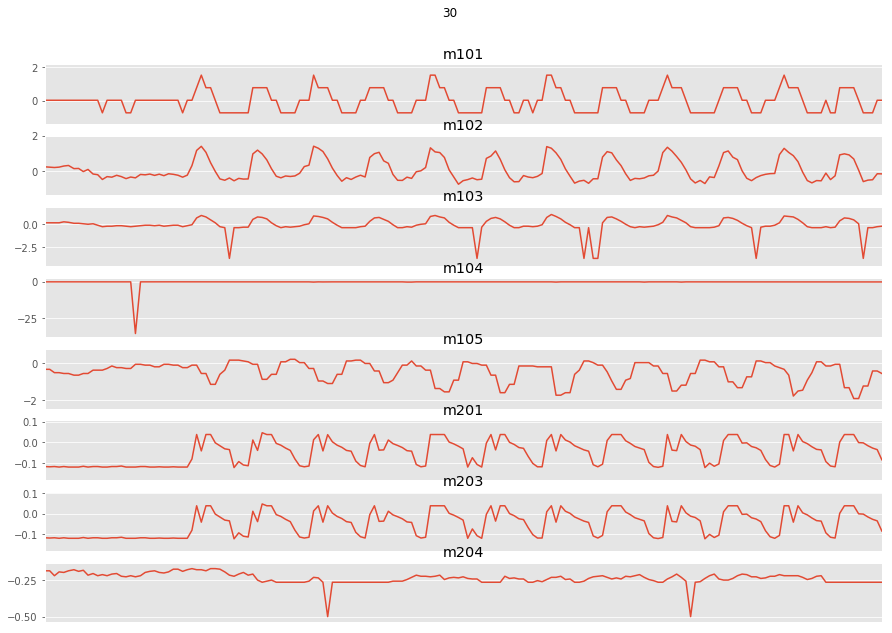

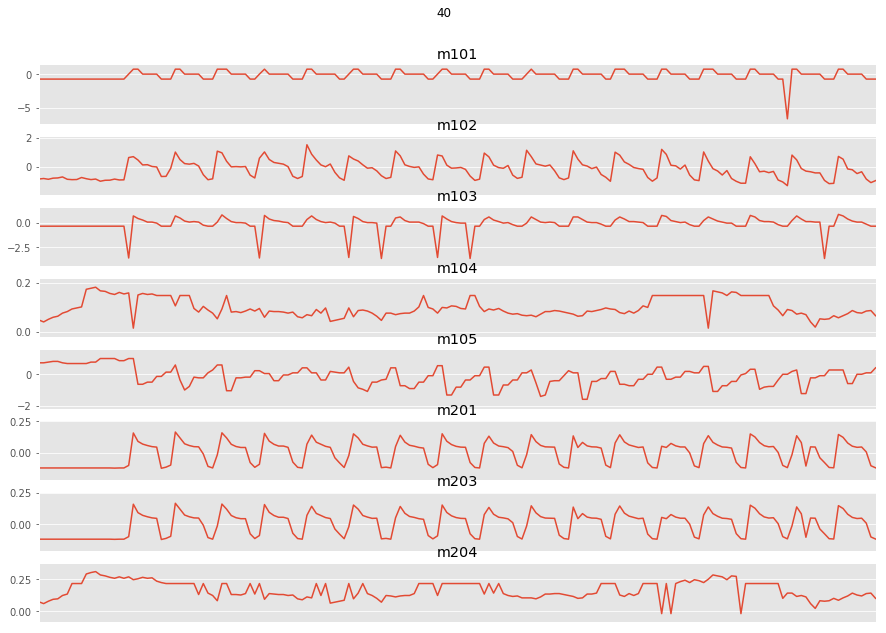

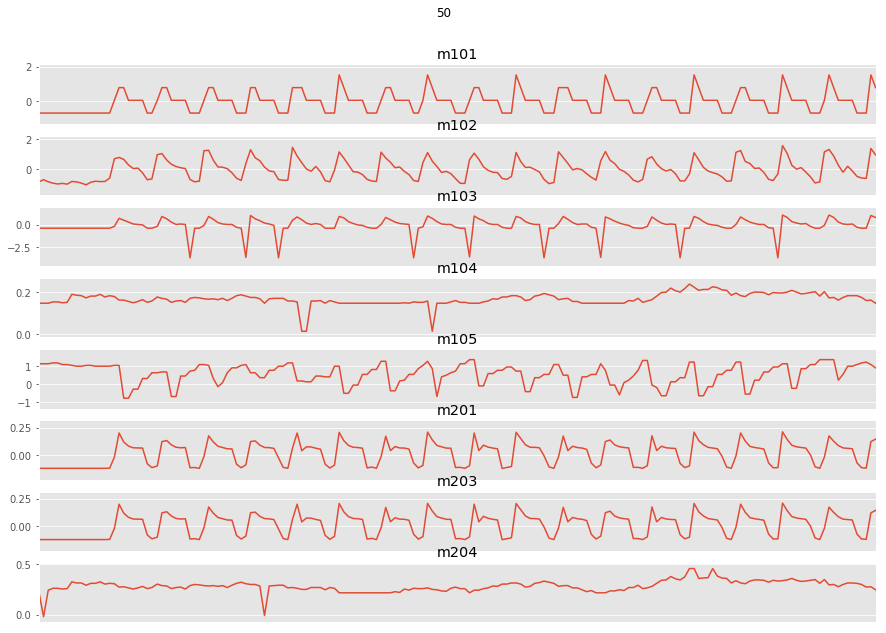

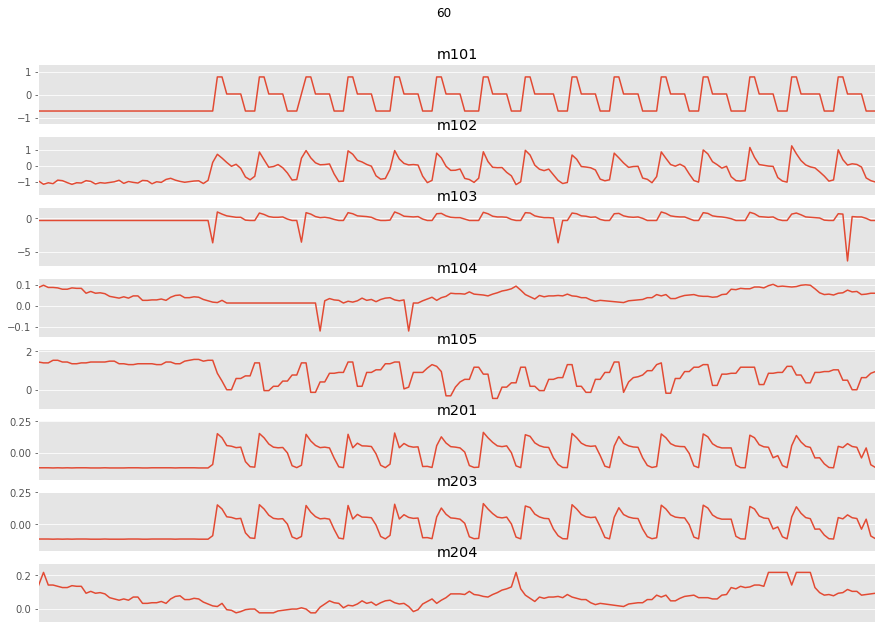

In [5]:
#180 equals sample rate => 180 features per sample
for activity in np.unique(dataset["id"]):
    subset = dataset[dataset["id"] == activity][:180]
    plot_activity(activity,subset)

In [6]:
dataset.head()

,zeitstempel,id,m101,m102,m103,m104,m105,m201,m203,m204
0,1530731271931,10,-0.698019,-1.011740,-0.366116,0.322742,0.722867,-0.118781,-0.118690,0.557329
1,1530731272522,10,-0.698019,-1.028762,-0.366116,0.346121,0.722867,-0.118780,-0.118690,0.598564
2,1530731273062,10,-0.698019,-0.983492,-0.366116,0.333369,0.722867,-0.118781,-0.118690,0.576072
3,1530731273604,10,-0.698019,-1.114472,-0.366116,0.326993,0.722867,-0.120049,-0.119947,0.564826
4,1530731274142,10,-0.698019,-1.075480,-0.366116,0.314241,0.722867,-0.118782,-0.118690,0.542334


In [7]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
        
def segment_signal(data,window_size = 12):
    #Return a new array of given shape and type, without initializing entries.
    segments = np.empty((0,window_size,8))
    labels = np.empty((0))
    for (start, end) in windows(data["zeitstempel"], window_size):
        mid101 = data["m101"][start:end]
        mid102 = data["m102"][start:end]
        mid103 = data["m103"][start:end]
        mid104 = data["m104"][start:end]
        mid105 = data["m105"][start:end]
        mid201 = data["m201"][start:end]
        mid203 = data["m203"][start:end]
        mid204 = data["m204"][start:end]
        if(len(dataset["zeitstempel"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([mid101,mid102,mid103,mid104,mid105,mid201,mid203,mid204])])
            labels = np.append(labels,stats.mode(data["id"][start:end])[0][0])
    return segments, labels

In [8]:
segments, labels = segment_signal(dataset)
print(segments.shape)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)

# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (10 X 8)
numOfRows = segments.shape[1]
print(numOfRows)
numOfColumns = segments.shape[2]
print(numOfColumns)


(1466, 12, 8)
12
8


In [9]:
train_test_split = np.random.rand(len(segments)) < 0.60
train_x = segments[train_test_split]
train_y = labels[train_test_split]
test_x = segments[~train_test_split]
test_y = labels[~train_test_split]
labels

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=int8)

In [10]:
numClasses = labels.shape[1]
print(numClasses)

6


In [11]:
#Importing convolutional layers
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

def cnnModel():
    #Initialising the CNN
    model = Sequential()

    #Input shape must be explicitly defined, DO NOT USE (None,shape)!!!
    #1.Multiple convolution and max pooling
    model.add(Convolution1D(filters=64, kernel_size=2, padding = "causal",activation="relu", input_shape=(numOfRows,numOfColumns)))
    model.add(MaxPooling1D(strides=2))
    model.add(BatchNormalization())
    model.add(Convolution1D(filters=64, kernel_size=2, padding = "causal",activation='relu'))
    model.add(MaxPooling1D(strides=2))
    model.add(BatchNormalization())
    model.add(Convolution1D(filters=128, kernel_size=2, padding = "causal",activation='relu'))
    #model.add(MaxPooling1D(strides=2))
    model.add(BatchNormalization())
    #classifier.add(Convolution1D(filters=64, kernel_size=11, activation='relu'))
    #classifier.add(MaxPooling1D(strides=4))

    #2.Flattening
    model.add(Flatten())


    #3.Full Connection
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(numClasses, activation='sigmoid'))
              
    #Configure the learning process
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 890 samples, validate on 576 samples
Epoch 1/30
 - 1s - loss: 0.4609 - acc: 0.7848 - val_loss: 0.2952 - val_acc: 0.9071
Epoch 2/30
 - 0s - loss: 0.2281 - acc: 0.9184 - val_loss: 0.1956 - val_acc: 0.9332
Epoch 3/30
 - 0s - loss: 0.1586 - acc: 0.9412 - val_loss: 0.1515 - val_acc: 0.9552
Epoch 4/30
 - 0s - loss: 0.1330 - acc: 0.9478 - val_loss: 0.1474 - val_acc: 0.9502
Epoch 5/30
 - 0s - loss: 0.1118 - acc: 0.9573 - val_loss: 0.1214 - val_acc: 0.9653
Epoch 6/30
 - 0s - loss: 0.0920 - acc: 0.9654 - val_loss: 0.1235 - val_acc: 0.9656
Epoch 7/30
 - 0s - loss: 0.0834 - acc: 0.9669 - val_loss: 0.1110 - val_acc: 0.9667
Epoch 8/30
 - 0s - loss: 0.0793 - acc: 0.9667 - val_loss: 0.0997 - val_acc: 0.9734
Epoch 9/30
 - 0s - loss: 0.0669 - acc: 0.9757 - val_loss: 0.1005 - val_acc: 0.9734
Epoch 10/30
 - 0s - loss: 0.0663 - acc: 0.9772 - val_loss: 0.0979 - val_acc: 0.9740
Epoch 11/30
 - 0s - loss: 0.0604 - acc: 

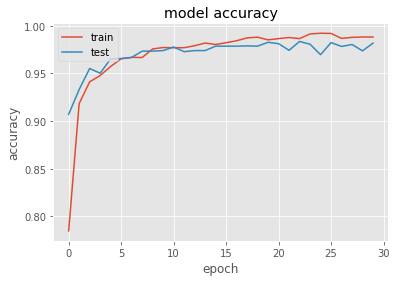

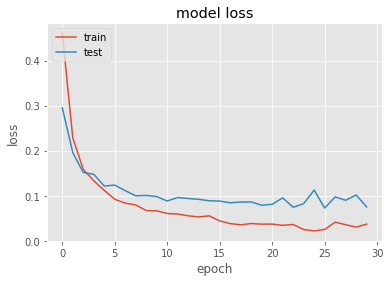

In [12]:
model = cnnModel()
#Train!
history = model.fit(train_x, train_y, epochs=30, validation_data=(test_x,test_y),batch_size = 40, verbose = 2)

score = model.evaluate(test_x, test_y, batch_size = 10)
print('Baseline Error: %.2f%%' %(100-score[1]*100))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()